<a href="https://colab.research.google.com/github/DerNiccoo/TheEarlyBird/blob/main/Aufgabe4/Nico/Aufgabenblatt_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount("/content/drive")

KeyboardInterrupt: ignored

In [5]:
import pandas as pd
url = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv'
df = pd.read_csv(url, error_bad_lines=False, sep=';', names=['labels','text'])

In [6]:
df = df.drop('labels', axis = 1)
df

,text
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,"'Erfundene Bilder zu Filmen, die als verloren ..."
2,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Estland sieht den künftigen österreichischen P...
...,...
9240,Bernd Saurer war Bridge-Juniorenweltmeister un...
9241,Sandhere soll in vergangener Woche bei Luftang...
9242,Derzeit Konzeptgruppe in Berlin – Kein Komment...
9243,Landeshauptmann will den vierten Regierungssit...


In [1]:
!pip install -U spacy[cuda100] de
!python -m spacy download de

     |████████████████████████████████| 10.0MB 11.6MB/s 
     |████████████████████████████████| 2.1MB 49.4MB/s 
     |████████████████████████████████| 370.3MB 46kB/s 
  Created wheel for de: filename=de-0.1-cp36-none-any.whl size=1158 sha256=e651ec1c7451006df9870c378eebb8c47ff71b549a0df1901dd00d0b00fb9671
  Stored in directory: /root/.cache/pip/wheels/fd/16/b9/46fac6c03128929538323f5457e947af752b7c58d4c7783f04
Successfully built de
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 14.9MB 26.6MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.3.0-cp36-none-any.whl size=14907580 sha256=9af63f1e51341d220779c787af9999eb31603d3ec96ebf755bb3abb0746c2796
  Stored in directory: /tmp/pip-ephem-wheel-cache-zdos9j7g/wheels/db/f3/1e/0df0f27eee12bd1aaa94bcfef1

In [2]:
import spacy
gpu = spacy.prefer_gpu()
print('GPU:', gpu)

GPU: True


In [8]:
nlp = spacy.load('de')

list_nouns =[]
df = df[0:200]

for index, row in df.iterrows():
  doc = nlp(row['text'])
  for token in doc:
    if token.pos_ == 'NOUN': 
      list_nouns.append(token.text)

In [13]:
import string

all_letters = string.ascii_letters + 'ÄÖÜäöüß'
list_nouns_ascii = []

for noun in list_nouns:
  contained = True
  
  for char in noun:
    if char not in all_letters:
      contained = False
      break

  if contained:
    list_nouns_ascii.append(noun)

In [35]:
n_categories = 1
all_categories = ['NOUN']

category_lines = {}
category_lines['NOUN'] = list_nouns_ascii

In [44]:
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

cuda:0


In [37]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [38]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [45]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor.to(device), input_line_tensor.to(device), target_line_tensor.to(device)

In [46]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [47]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [48]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [49]:
n_letters = len(all_letters) + 1
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 36s (5000 5%) 3.0581
1m 13s (10000 10%) 2.6782
1m 50s (15000 15%) 2.9709
2m 25s (20000 20%) 1.9660
3m 0s (25000 25%) 3.0792
3m 34s (30000 30%) 2.7516
4m 9s (35000 35%) 2.6358
4m 44s (40000 40%) 3.2830
5m 18s (45000 45%) 1.8738
5m 53s (50000 50%) 2.9594
6m 27s (55000 55%) 2.4633
7m 1s (60000 60%) 1.2685
7m 37s (65000 65%) 1.5727
8m 11s (70000 70%) 2.7322
8m 45s (75000 75%) 2.6929
9m 20s (80000 80%) 2.7112
9m 54s (85000 85%) 2.3699
10m 29s (90000 90%) 2.0698
11m 4s (95000 95%) 2.1241
11m 39s (100000 100%) 1.1351


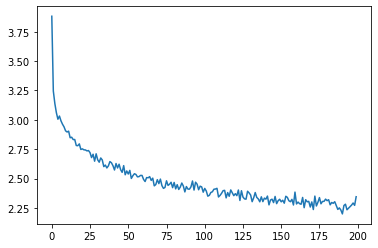

In [50]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [54]:
max_length = 20

# Sample from a category and starting letter
def sample(start_letter='A', category='NOUN'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(start_letters='ABC', category = 'NOUN'):
    for start_letter in start_letters:
        print(sample(start_letter, category))

In [69]:
def sample_pre(start):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor('NOUN')
        input = inputTensor(start)
        hidden = rnn.initHidden()

        output_name = start

        for char in start[:-1]:
          input = inputTensor(char)
          output, hidden = rnn(category_tensor, input[0], hidden)

        input = inputTensor(start[-1])

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [77]:
sample_pre("Alina")

'Alinatt'